In [87]:
# importing packages
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# PRE PROCESSING FROM CLEANSED DATA FILE

In [88]:
# import cleansed data
file_path = Path("Data/churn_data.csv")

In [89]:
# Create a DataFrame
churn_data_df = pd.read_csv(file_path)
churn_data_df.head(5)

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1


In [90]:
# View of data set
churn_data_df.describe()

,zip,lat,long,tenure,monthly_charges,total_charges,churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,93523.032565,36.283307,-119.799215,32.421786,64.798208,2283.300441,0.265785
std,1865.515958,2.456118,2.157588,24.545260,30.085974,2266.771362,0.441782
min,90001.000000,32.555828,-124.301372,1.000000,18.250000,18.800000,0.000000
25%,92102.000000,34.030915,-121.815412,9.000000,35.587500,401.450000,0.000000
50%,93552.500000,36.391777,-119.735410,29.000000,70.350000,1397.475000,0.000000
75%,95354.000000,38.227285,-118.043237,55.000000,89.862500,3794.737500,1.000000
max,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000


In [91]:
# Encode all the categorical data
categorical_cols = ['city', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service',
                   'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                    'contract', 'paperless_billing', 'payment_method']
encoders = {}

for i in categorical_cols:
    encoders[i] = LabelEncoder()
    churn_data_df[i] = encoders[i].fit_transform(churn_data_df[i])

churn_data_df.head()

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,562,90003,33.964131,-118.272783,1,0,0,0,2,1,...,0,0,0,0,0,1,3,53.85,108.15,1
1,562,90005,34.059281,-118.307420,0,0,0,1,2,1,...,0,0,0,0,0,1,2,70.70,151.65,1
2,562,90006,34.048013,-118.293953,0,0,0,1,8,1,...,2,0,2,2,0,1,2,99.65,820.50,1
3,562,90010,34.062125,-118.315709,0,0,1,1,28,1,...,2,2,2,2,0,1,2,104.80,3046.05,1
4,562,90015,34.039224,-118.266293,1,0,0,1,49,1,...,2,0,2,2,0,1,0,103.70,5036.30,1


In [92]:
# Split the data into X and y features
#X = churn_data_df.iloc[:, :-1]
#y = churn_data_df.iloc[:, -1]

X = churn_data_df.drop(columns= 'churn')
y = churn_data_df['churn']

In [93]:
# Summary stats of data set
X.describe()

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,593.711889,93523.032565,36.283307,-119.799215,0.504693,0.162400,0.482509,0.230375,32.421786,0.903299,...,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208,2283.300441
std,314.937096,1865.515958,2.456118,2.157588,0.500014,0.368844,0.499729,0.421103,24.545260,0.295571,...,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362
min,0.000000,90001.000000,32.555828,-124.301372,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000
25%,337.000000,92102.000000,34.030915,-121.815412,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000
50%,601.000000,93552.500000,36.391777,-119.735410,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000
75%,869.000000,95354.000000,38.227285,-118.043237,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500
max,1128.000000,96161.000000,41.962127,-114.192901,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000


In [94]:
# Checking the balance of the Target values- Data is imbalanced.
y.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [95]:
# Creating Train and Test split for X and y- 80 to 20 split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=1)

In [96]:
# Data count for train and test
c= pd.DataFrame(y_train)
k = pd.DataFrame(y_test)
print(c['churn'].value_counts())
print(k['churn'].value_counts())

0    4106
1    1519
Name: churn, dtype: int64
0    1057
1     350
Name: churn, dtype: int64


In [97]:
# Creating standard scaler instance and fit the training data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [98]:
# Scaling Train and Test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# SIMPLE LOGISTIC REGRESSION CLASSIFIER

In [99]:
lr_clf = LogisticRegression(solver='lbfgs', random_state=1)
lr_clf.fit(X_train_scaled, y_train) 

LogisticRegression(random_state=1)

In [100]:
# Calculate the balanced accuracy score i.e. make predictions/calculate accuracy. Looks good in this instance.
y_pred = lr_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7284768211920529

In [101]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[936, 121],
       [150, 200]], dtype=int64)

<AxesSubplot:>

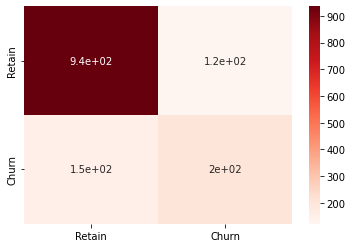

In [102]:
# Display Confusion Matrix heatmap
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [103]:
# Print the imbalanced classification report- based on below results model is performing well.
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.89      0.57      0.87      0.71      0.52      1057
          1       0.62      0.57      0.89      0.60      0.71      0.49       350

avg / total       0.80      0.81      0.65      0.80      0.71      0.51      1407



In [104]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.728476821192053

# Review results

Since the precision for predicting churn rate and recall is low, there is potentrial to improve this model.

# Over Sampling- does not help- makes precision worse!

In this section, will use oversampling alogrithm to balance the data set.

In [105]:
# Resample the training data with the RandomOversampler- note scaled data is resampled.
# implement random oversampling- all libraries loaded at the start
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({0: 4106, 1: 4106})

In [106]:
# Train the Logistic Regression model using the resampled data
lr_cf_model = LogisticRegression(solver='lbfgs', random_state=1)
lr_cf_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [107]:
# Calculate the balanced accuracy score
y_pred = lr_cf_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7551466414380321

In [108]:
y_test.describe()

count    1407.000000
mean        0.248756
std         0.432446
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

In [109]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[784, 273],
       [ 81, 269]], dtype=int64)

<AxesSubplot:>

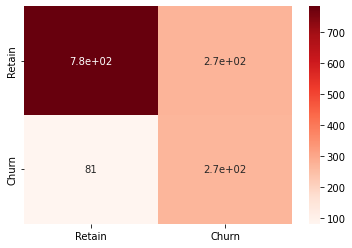

In [110]:
# Display Confusion Matrix heatmap
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [111]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.74      0.77      0.82      0.76      0.57      1057
          1       0.50      0.77      0.74      0.60      0.76      0.57       350

avg / total       0.80      0.75      0.76      0.76      0.76      0.57      1407



In [112]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.7551466414380322

# Balanced Random Forest Classifier

In [113]:
# Resample the training data with the BalancedRandomForestClassifier
brf_clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf_clf = brf_clf.fit(X_train_scaled, y_train)

In [114]:
# Calculated the balanced accuracy score
y_pred = brf_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7637369914853358

In [115]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[778, 279],
       [ 73, 277]], dtype=int64)

<AxesSubplot:>

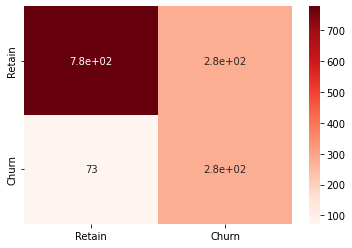

In [116]:
# Display the Confusion Matrix heatmap
brf_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(brf_clf_cm, annot=True, cmap='Reds')

In [117]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.74      0.79      0.82      0.76      0.58      1057
          1       0.50      0.79      0.74      0.61      0.76      0.59       350

avg / total       0.81      0.75      0.78      0.76      0.76      0.58      1407



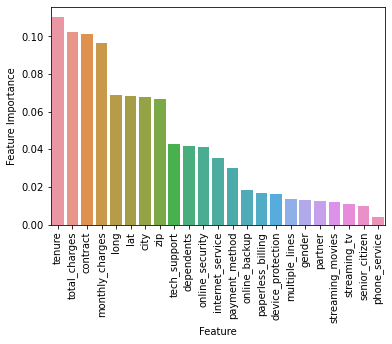

In [118]:
# List the features sorted in descending order by feature importance
feature_list = {i:j for i, j in zip(brf_clf.feature_importances_, X.columns)}
fi = pd.DataFrame(sorted(feature_list.items(), reverse=True), columns=['Feature Importance', 'Feature'])
plot = sns.barplot(x='Feature', y='Feature Importance', data=fi)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

# Easy Ensemble Classifier

In [119]:
# Train the Classifier
eec_clf = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_clf.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [120]:
# Calculated the balanced accuracy score
y_pred = eec_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7561684011352886

In [121]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[762, 295],
       [ 73, 277]], dtype=int64)

<AxesSubplot:>

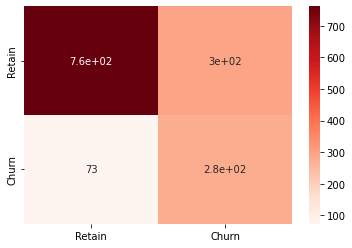

In [122]:
# Display the Confusion Matrix heatmap
eec_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(eec_clf_cm, annot=True, cmap='Reds')

In [123]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.72      0.79      0.81      0.76      0.57      1057
          1       0.48      0.79      0.72      0.60      0.76      0.57       350

avg / total       0.81      0.74      0.77      0.75      0.76      0.57      1407



# XGBOOST CLASSIFIER

In [124]:
# Train the XGBoost classifier
xgb_clf = XGBClassifier(random_state=1, 
                        learning_rate=0.35, 
                        eval_metric='mlogloss')

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.35, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [125]:
# Predict and Evaluate the results
y_pred = xgb_clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7051750236518448

In [126]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[926, 131],
       [163, 187]], dtype=int64)

<AxesSubplot:>

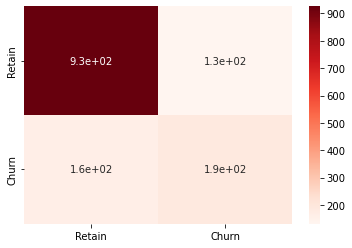

In [127]:
# Display the Confusion Matrix heatmap
xgb_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(xgb_clf_cm, annot=True, cmap='Reds')

In [128]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.88      0.53      0.86      0.68      0.48      1057
          1       0.59      0.53      0.88      0.56      0.68      0.45       350

avg / total       0.79      0.79      0.62      0.79      0.68      0.48      1407



<AxesSubplot:title={'center':'Feature Importance (XGBoost)'}, xlabel='F score', ylabel='Features'>

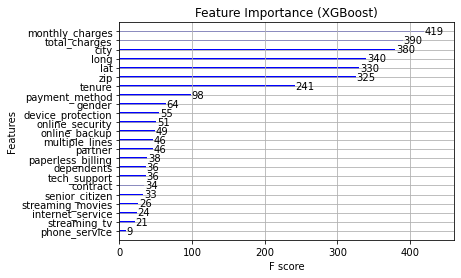

In [129]:
xgboost.plot_importance(xgb_clf, title="Feature Importance (XGBoost)", color='Blue')